In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np
pd.set_option("display.max_columns", None)  # sets the max
sns.set_style("whitegrid")


from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import scipy
from scipy.stats import ttest_ind, levene
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler


rs = 1  # random state seed for reproducibility

from pathlib import Path
import pickle

# Data Loading

In [2]:
df_org = pd.read_csv("data/all_survey_answers.csv", index_col=0)



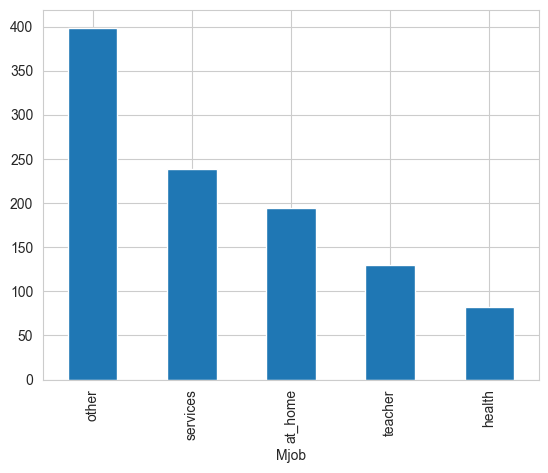

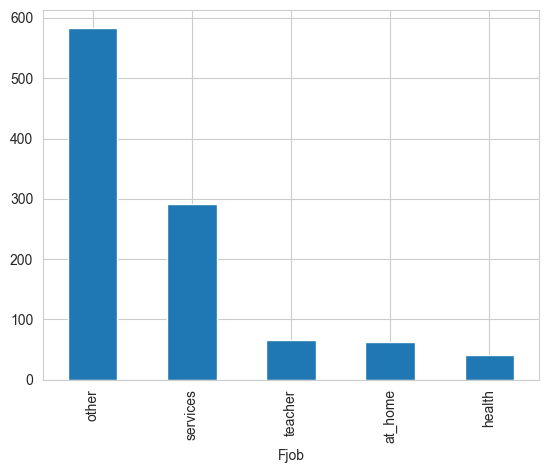

In [3]:
df_org.Mjob.value_counts().plot(kind="bar")
plt.show()
df_org.Fjob.value_counts().plot(kind="bar")
plt.show()

# Feature Engineering

## EDA

In [4]:
numeric_features = df_org.select_dtypes("number")
features = df_org .columns

### Correlation Analysis

<Axes: >

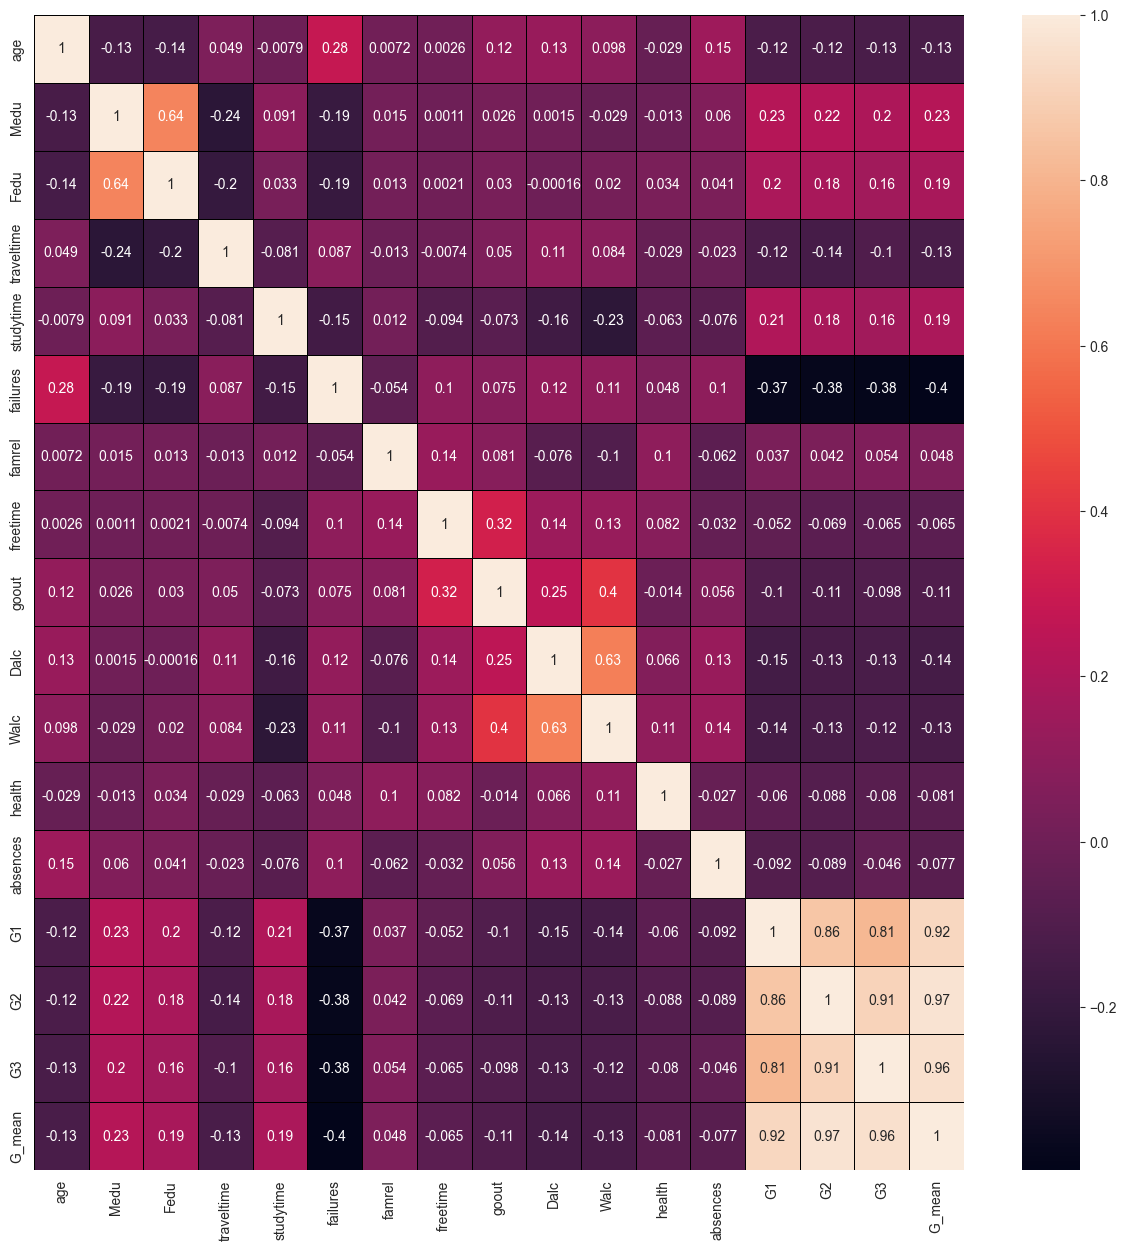

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(
    numeric_features.corr(method="pearson"),
    annot=True,
    cmap="rocket",
    linewidths=0.5,
    linecolor="black",
)

## SES Inference

In [6]:
ses_proxies = ["internet", "traveltime", "address", "Mjob", "Fjob", "Medu", "Fedu"]

### Variable variance exploration

changing nominal to ordinal types (not the approach they take in the SES PCA paper)

In [7]:
df_variance = df_org.copy()

df_variance['internet'] = df_variance['internet'].map({"no": 0, "yes": 1})
df_variance['address'] = df_variance['address'].map({"R": 0, "U": 1})
df_variance['Mjob'] = df_variance['Mjob'].map({"at_home": 0, "health": 1, "other": 2, "services": 3, "teacher": 4})
df_variance['Fjob'] = df_variance['Fjob'].map({"at_home": 0, "health": 1, "other": 2, "services": 3, "teacher": 4})

df_variance[ses_proxies].var(axis=0).sort_values(ascending=False)

Mjob          1.549563
Medu          1.265415
Fedu          1.209864
Fjob          0.745671
traveltime    0.535425
address       0.198656
internet      0.164809
dtype: float64

In [8]:
# One Hot Encoding features that are not numerical
df_ohe = pd.get_dummies(df_org[ses_proxies], columns=["Mjob", "Medu", "Fedu", "Fjob", "address", "traveltime"])
df_ohe['internet'] = df_ohe['internet'].map({"no": 0, "yes": 1})
df_ohe.head()

,internet,Mjob_at_home,Mjob_health,Mjob_other,Mjob_services,Mjob_teacher,Medu_0,Medu_1,Medu_2,Medu_3,Medu_4,Fedu_0,Fedu_1,Fedu_2,Fedu_3,Fedu_4,Fjob_at_home,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,address_R,address_U,traveltime_1,traveltime_2,traveltime_3,traveltime_4
0,0,True,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,True,False,False
1,1,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False
2,1,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False
3,1,False,True,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False
4,0,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,True,False,False,False


In [9]:
# Variance of the one-hot encoded features (all features are binary in df_ohe)
df_ohe.var().sort_values(ascending=False)

Fjob_other       0.246709
traveltime_1     0.240871
Mjob_other       0.236346
Fedu_2           0.214236
traveltime_2     0.212767
Medu_4           0.207392
Fjob_services    0.201658
Medu_2           0.200383
address_U        0.198656
address_R        0.198656
Fedu_1           0.185260
Mjob_services    0.176689
Medu_3           0.176168
Fedu_3           0.172472
Fedu_4           0.168685
internet         0.164809
Medu_1           0.156199
Mjob_at_home     0.151438
Mjob_teacher     0.109120
Mjob_health      0.072444
traveltime_3     0.068381
Fjob_teacher     0.058440
Fjob_at_home     0.055914
Fjob_health      0.037766
traveltime_4     0.022482
Fedu_0           0.008555
Medu_0           0.008555
dtype: float64

### Socio economic status (SES) inference using PCA analysis
This approach makes two major assumptions:
1. The variables used are reasonable proxies for SES
2. That the sample is representative of the SES spectrum
   - We use PCA on variables we believe are proxies of SES, and find lower dimensions of the data that maximises variance. The motivation is that if the variables are in fact proxies for SES, then we will see a latent structure in the PCA data.

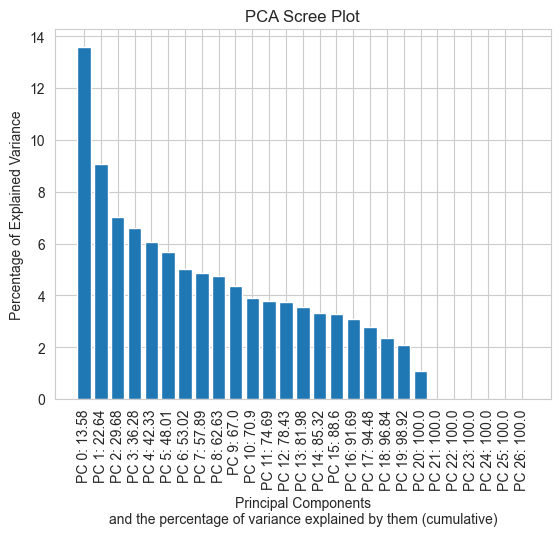

In [10]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_ohe)

# perform PCA
pca = PCA()
pca.fit_transform(scaled_data)

# get variance ratios
scree = list(pca.explained_variance_ratio_ * 100)

# get cumulative variance ratios
cumulative_scree = [sum(scree[: i + 1]) for i in range(len(scree))]

# make labels for scree plot
labels = [
    f"PC {str(i)}: {round(cumulative_scree[i], 2)}"
    for i in range(0, len(cumulative_scree))
]

# Plot principle components
plt.bar(x=range(1, len(scree) + 1), height=scree, tick_label=labels)
plt.ylabel("Percentage of Explained Variance")
plt.xlabel("Principal Components\nand the percentage of variance explained by them (cumulative)")
plt.xticks(rotation=90)
plt.title("PCA Scree Plot")
plt.savefig("plots/scree_plot.png", transparent=True, bbox_inches="tight", dpi=300)
plt.show()

In [11]:
# make a dataframe of the PCA coordinates
pca1 = PCA(n_components=4)
df_pca = pd.DataFrame(
    pca1.fit_transform(scaled_data), columns=["PC1", "PC2", "PC3", "PC4"]
)

In [12]:
# 2D plot (was not really useful)
fig = px.scatter(
    x=df_pca.PC1, y=df_pca.PC3, color=df_org.G3, color_continuous_scale="tempo"
)
# set x and y labels
fig.update_layout(
    xaxis_title="PC1",
    yaxis_title="PC2",
    title={
        "text": "PCA on SES Proxies",
        "y": 0.95,
        "x": 0.5,
        "xanchor": "center",
        "yanchor": "top",
    },
    coloraxis_colorbar=dict(title="Final Grade"),
)

fig.update_traces(mode="markers")
fig.show()

#### Analysing factor scores and variable precense in principle components

In [13]:
# Get the factor scores for each feature
factor_scores_PC1 = pca.components_[0]
factor_scores_df = pd.DataFrame(
    {"factor_scores": factor_scores_PC1, "features": df_ohe.columns}
).sort_values(by="factor_scores", ascending=False)

factor_scores_df.set_index("features", inplace=True)
factor_scores_df

,factor_scores
features,
address_R,0.280172
Medu_1,0.265666
Fedu_1,0.264933
Mjob_at_home,0.212313
Fjob_other,0.186489
traveltime_2,0.172726
Mjob_other,0.170600
traveltime_3,0.154010
Medu_2,0.146295


C:\Users\caspe\AppData\Local\Temp\ipykernel_5732\2900065816.py:32: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



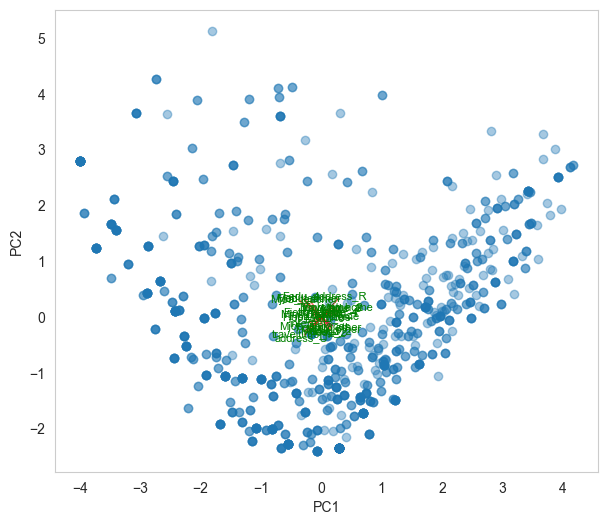

In [14]:
# Make biplot
pca_variable_explained = pd.DataFrame(pca.components_, columns=df_ohe.columns)

fig, ax = plt.subplots(figsize=(7, 6), dpi=100)
ax.scatter(df_pca["PC1"], df_pca["PC2"], alpha=0.4)

for i in pca_variable_explained:
    current_arrow = pca_variable_explained[i][:2]
    ax.arrow(
        0,
        0,
        current_arrow[0],
        current_arrow[1],
        color="r",
        alpha=0.5,
        length_includes_head=True,
        head_width=0.02,
        head_length=0.02,
    )
    ax.text(
        current_arrow[0] * 1.15,
        current_arrow[1] * 1.15,
        i,
        color="g",
        ha="center",
        va="center",
        fontsize=8,
    )
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
fig.show()

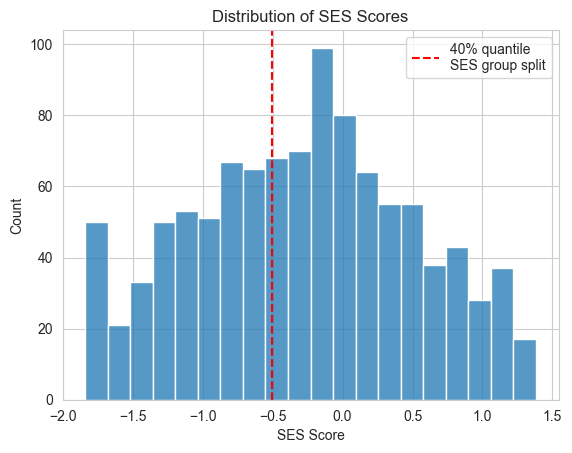

In [15]:
# Aggregate factor scores for each row to calculate SES scores
ses_scores = {}

for idx, row in df_ohe.iterrows():
    current_ses_score = 0
    
    # Calculate the SES score for each row based on the one-hot encoded features
    for i in range(len(row)):
        if row[i] == 1:
            current_feature = df_ohe.columns[i]
            current_ses_score += factor_scores_df.loc[current_feature].values[0] 
    
    ses_scores[idx] = current_ses_score

# Add SES scores to the original DataFrame
df_ohe['SES_score'] = pd.DataFrame.from_dict(ses_scores, orient='index', columns=['SES_score'])['SES_score']

# Plot the distribution of SES scores
sns.histplot(df_ohe['SES_score'], bins=20)
plt.title("Distribution of SES Scores")
plt.xlabel("SES Score")

# Add a vertical line at the 40% quantile
quantile_40 = df_ohe['SES_score'].quantile(0.4)
plt.axvline(x=quantile_40, color='red', linestyle='dashed', label='40% quantile\nSES group split')
plt.legend()

# Save the plot to a file
plt.savefig("plots/ses_score_distribution.png", transparent=True, bbox_inches="tight", dpi=300)

# Show the plot
plt.show()

#### Create Socio economic status variable

In [16]:
quantile_60 = df_ohe['SES_score'].quantile(0.6) # 60th percentile
df_org['SES_score'] = df_ohe['SES_score']
df_org['SES'] = df_ohe['SES_score'].apply(lambda x: 'middle/rich' if x < quantile_60 else 'lower')
df_org.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,course,G_mean,SES_score,SES
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,math,5.666667,-0.733077,middle/rich
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,math,5.333333,0.176471,lower
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,math,8.333333,0.176471,lower
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,math,14.666667,-1.234671,middle/rich
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,math,8.666667,-0.323278,middle/rich


In [17]:
pd.DataFrame(df_org['SES'].value_counts())

,count
SES,
middle/rich,625
lower,419


In [18]:
# check that the rich/middle has higher grades than the lower class
pd.DataFrame(df_org.groupby("SES")["G3"].mean())

,G3
SES,
lower,10.568019
middle/rich,11.860800


### Statistical tests to check if mean final grade across SES groups is statistically significant

In [19]:
alpha = 0.05/4  # significance level with bonferonni correction

cols = ["G3", "SES"]
df_math = df_org[df_org["course"] == "math"][cols]
df_port = df_org[df_org["course"] == "portuguese"][cols]

df_math_upper = df_math[df_math["SES"] == "middle/rich"]["G3"]
df_math_lower = df_math[df_math["SES"] == "lower"]["G3"]

df_port_upper = df_port[df_port["SES"] == "middle/rich"]["G3"]
df_port_lower = df_port[df_port["SES"] == "lower"]["G3"]

# Levens test to test for difference in final grade variance between SES groups is significant in both math and portuguese:
lev_math_s, lev_math_p = levene(df_math_upper, df_math_lower)
lev_port_s, lev_port_p = levene(df_port_upper, df_port_lower)

math_var_diff = lev_math_p > alpha
port_var_diff = lev_port_p > alpha
# if True, then the variance is not significantly different between the two groups

# If equal_var is set to True (lev_test is not significant), then a Welch t-test is performed. Otherwise, a Student t-test is performed to compare the means of two independent samples.
t_math_s, t_math_p = ttest_ind(df_math_upper, df_math_lower, equal_var=math_var_diff)
t_port_s, t_port_p = ttest_ind(df_port_upper, df_port_lower, equal_var=port_var_diff)

print(
    f"""
Is difference in final grade math significant between SES groups: {t_math_s} (p: {ttest_ind(
    df_math_upper, df_math_lower, equal_var=lev_math_s
)[1]})

Is difference in final grade port significant between SES groups: {t_port_s} (p: {ttest_ind(df_port_upper, df_port_lower, equal_var=lev_port_s)[1]})
      """
)


Is difference in final grade math significant between SES groups: 3.302844981214936 (p: 0.0010447794690114252)

Is difference in final grade port significant between SES groups: 5.822166082337775 (p: 9.149446342332715e-09)
      


### Sensitive Variables

In [20]:
df = df_org
df_math = df[df["course"] == "math"]
df_port = df[df["course"] == "portuguese"]

print("portuguese")
print(df_port[df_port['G3'] >= 10].shape[0])
print(df_port[df_port['G3'] < 10].shape[0])

print()

print("math")
print(df_math[df_math['G3'] >= 10].shape[0])
print(df_math[df_math['G3'] < 10].shape[0])

portuguese
549
100

math
265
130


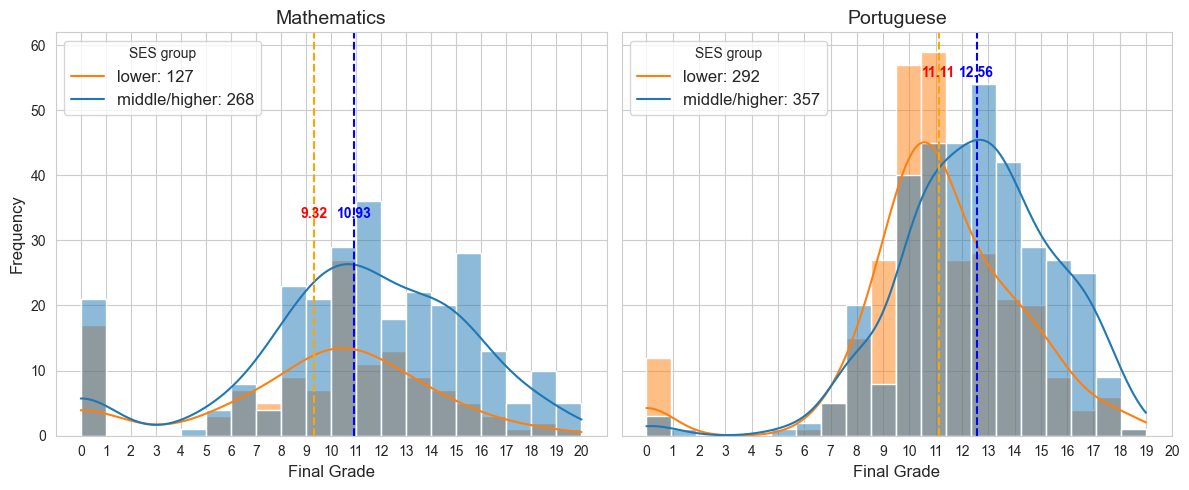

In [21]:
def plot_final_grade_distribution(df: pd.DataFrame):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
    title_fontsize = 14
    axis_fontsize = 12
    
    df_math = df[df["course"] == "math"]
    df_port = df[df["course"] == "portuguese"]

    # Get mean final grade for each SES group for both courses
    lower_mean_math, middle_rich_mean_math = df_math.groupby("SES")["G3"].mean()
    lower_mean_port, middle_rich_mean_port = df_port.groupby("SES")["G3"].mean()

    # Create Final grade distribution plot
    n_middle_rich_math, n_lower_math = df_math["SES"].value_counts()
    n_middle_rich_port, n_lower_port = df_port["SES"].value_counts()

    # Math plot
    sns.histplot(x="G3", hue="SES", data=df_math, kde=True, bins=20, ax=ax1)
    ax1.set_title(f"Mathematics", fontsize=title_fontsize)
    ax1.set_xticks(np.arange(0, 21, 1))
    ax1.set_xlabel("Final Grade", fontsize=axis_fontsize)
    ax1.set_ylabel("Frequency", fontsize=axis_fontsize)
    ax1.legend(
        title="SES group",
        loc="upper left",
        labels=[f"lower: {n_lower_math}", f"middle/higher: {n_middle_rich_math}"],
        fontsize=axis_fontsize,
    )

    # mean lines
    ax1.axvline(
        lower_mean_math,
        color="orange",
        linestyle="--",
        label=f"Lower Mean: {lower_mean_math:.2f}",
    )
    ax1.axvline(
        middle_rich_mean_math,
        color="blue",
        linestyle="--",
        label=f"Middle/Higher Mean: {middle_rich_mean_math:.2f}",
    )

    # Display mean values on the lines
    ax1.text(
        lower_mean_math,
        plt.gca().get_ylim()[1] * 0.9,
        f"{lower_mean_math:.2f}",
        color="red",
        ha="center",
        va="center",
        weight="bold",
    )
    ax1.text(
        middle_rich_mean_math,
        plt.gca().get_ylim()[1] * 0.9,
        f"{middle_rich_mean_math:.2f}",
        color="blue",
        ha="center",
        va="center",
        weight="bold",
    )

    # Portugese plot
    sns.histplot(x="G3", hue="SES", data=df_port, kde=True, bins=20, ax=ax2)
    ax2.set_title(f"Portuguese", fontsize=title_fontsize)
    ax2.set_xticks(np.arange(0, 21, 1))
    ax2.set_xlabel("Final Grade", fontsize=axis_fontsize)
    ax2.legend(
        title="SES group",
        loc="upper left",
        labels=[f"lower: {n_lower_port}", f"middle/higher: {n_middle_rich_port}"],
        fontsize=axis_fontsize,
    )

    # mean lines
    ax2.axvline(
        lower_mean_port,
        color="orange",
        linestyle="--",
        label=f"Lower Mean: {lower_mean_port:.2f}",
    )
    ax2.axvline(
        middle_rich_mean_port,
        color="blue",
        linestyle="--",
        label=f"Middle/Higher Mean: {middle_rich_mean_port:.2f}",
    )

    # Display mean values on the lines
    ax2.text(
        lower_mean_port,
        plt.gca().get_ylim()[1] * 0.9,
        f"{lower_mean_port:.2f}",
        color="red",
        ha="center",
        va="center",
        weight="bold",
    )
    ax2.text(
        middle_rich_mean_port,
        plt.gca().get_ylim()[1] * 0.9,
        f"{middle_rich_mean_port:.2f}",
        color="blue",
        ha="center",
        va="center",
        weight="bold",
    )

    plt.savefig(
        f"plots/grade_distribution_by_SES.png",
        dpi=300,
        transparent=True,
        bbox_inches="tight",
    )
    plt.tight_layout()
    plt.show()


plot_final_grade_distribution(df)

### Correlation analysis on SES with non-proxy variables

In [22]:
df_ses = df.copy()
corr_dict = {}

unused_cols = ["G1", "G2", "G3", "G_mean", "SES_score", "sex", "age"]  # drop
ses_proxis = [
    "internet",
    "traveltime",
    "address",
    "Medu",
    "Fedu",
    "Mjob",
    "Fjob",
]  # exclude
df_ses = df_ses.drop(columns=unused_cols + ses_proxis)

## MATH
df_math = df_ses[df_ses["course"] == "math"]
df_math = pd.get_dummies(df_math, drop_first=True)

df_corr = pd.DataFrame(
    df_math.corrwith(df_math["SES_middle/rich"], method="pearson"),
    columns=["Mathematics"],
)

## Portuguese
df_port = df_ses[df_ses["course"] == "portuguese"]
df_port = pd.get_dummies(df_port, drop_first=True)
df_corr['Portuguese'] = df_port.corrwith(df_port["SES_middle/rich"], method="pearson")

df_corr = df_corr[:-1] # remove SES_middle/rich
df_corr

# sort values in df_corr by the sum of the absolute values of the correlation
df_corr['absolute_sum'] = df_corr.abs().sum(axis=1)
df_corr = df_corr.sort_values(by='absolute_sum', ascending=False)
df_corr = df_corr[['Mathematics', 'Portuguese']]

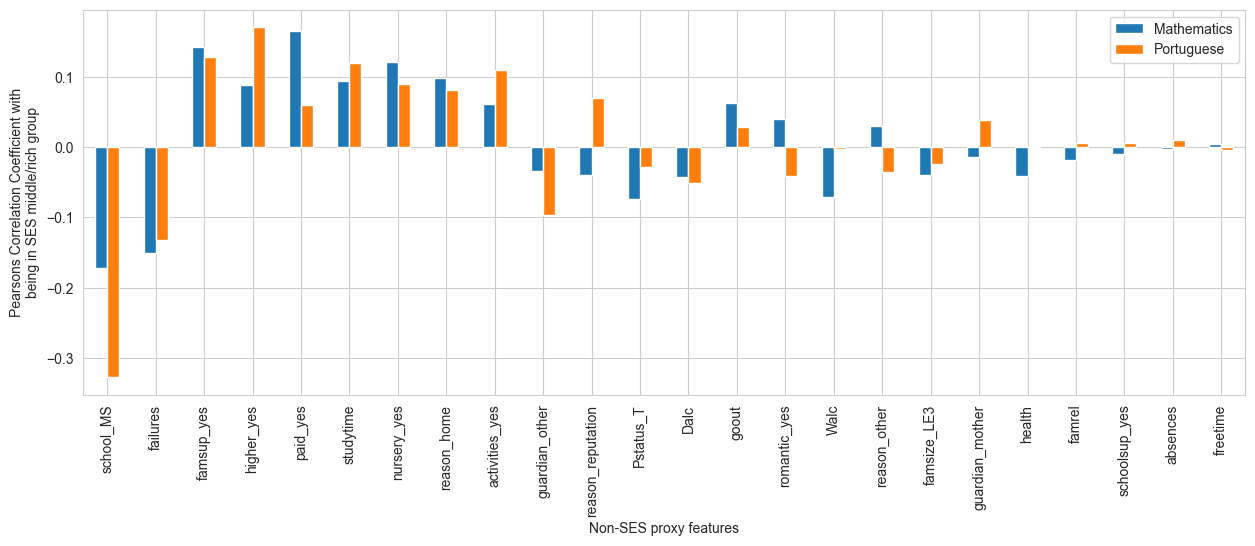

In [23]:
df_corr.plot(kind='bar', figsize=(15, 5))
plt.ylabel("Pearsons Correlation Coefficient with\nbeing in SES middle/rich group")
plt.xlabel("Non-SES proxy features")
plt.savefig(f"plots/SES_corr_with_non_proxy_features_1.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

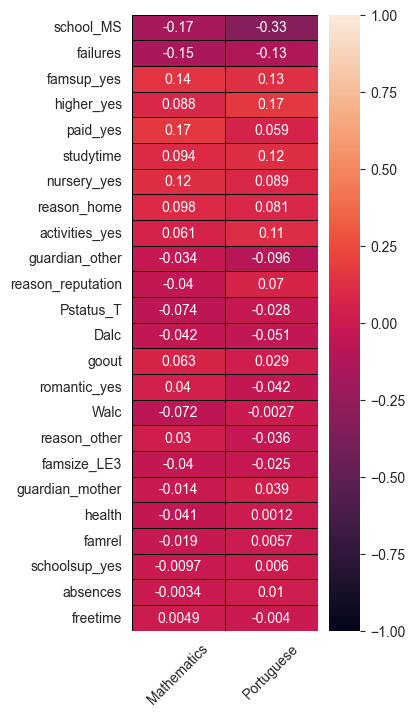

In [24]:
# Plot results
fig, ax = plt.subplots(1, 1, figsize=(3, 8))
sns.heatmap(pd.DataFrame(df_corr), annot=True, vmin=-1, vmax=1, cmap="rocket", linewidths=0.5, linecolor="black", ax=ax)
#ax.set_title("Pearsons Correlation Coefficient with\nSES_middle/rich for non-proxy SES features", fontsize=14)
ax.set_xticks([0.5, 1.5], ["Mathematics", "Portuguese"], rotation=45) # remove xticks
plt.savefig(f"plots/SES_corr_with_non_proxy_features.png", dpi=300, transparent=True, bbox_inches="tight")
plt.show()

# Fair PCA Experiments

## Functions

### Fair PCA

In [25]:
def fair_PCA(X, protected_features, n_components):

    Z = np.copy(protected_features)

    # Removing the mean from the protected features
    Z = Z-np.mean(Z)

    # Finding the orthonormal null-space spanned by Z^t X

    R = scipy.linalg.null_space(np.matmul(Z.T, X))
    
    # Finding the orthonormal eigenvectors of R^T X^T X R
    vals, L = scipy.linalg.eig(np.linalg.multi_dot([np.transpose(R), np.transpose(X), X, R]))

    #sort by eigen values
    idx = vals.argsort()[::-1]
    L = L[:,idx]


    # Finding the projection matrix
    U = np.matmul(R, L[:n_components])

    # Projecting our data into fair space and returning X'
    return U, np.matmul(np.transpose(U),np.transpose(X))

### Fairness metrics (Equalized odds)

In [26]:
def fpr_and_tpr(cm):
    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]
    TP = cm[1][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)

    return FPR, TPR

def equalized_odds(
        model,
        X,
        y,
        groups,
        group_protected,
        group_non_protected
    ):
    
    X_protected = X[groups == group_protected]
    y_protected = y[groups == group_protected]
    predictions_protected = model.predict(X_protected)


    X_non_protected = X[groups == group_non_protected]
    y_non_protected = y[groups == group_non_protected]
    predictions_non_protected = model.predict(X_non_protected)

    cm_protected = confusion_matrix(y_protected, predictions_protected)
    cm_non_protected = confusion_matrix(y_non_protected, predictions_non_protected)

    FPR_protected, TPR_protected = fpr_and_tpr(cm_protected)
    FPR_non_protected, TPR_non_protected = fpr_and_tpr(cm_non_protected)

    return pd.DataFrame({"FPR":[FPR_protected, FPR_non_protected], "TPR":[TPR_protected,TPR_non_protected]}, index=[group_protected,group_non_protected])


### Main experiment class

In [27]:
class Experiment:
    def __init__(
            self, 
            data,
            course,
            grade_threshold,
            test_ratio,
            random_state
        ):

        self.course = course
        self.random_state = random_state
        self.test_ratio = test_ratio

        self.data = data[data["course"] == self.course]

        self.target = data[data["course"] == self.course]["G3"].apply(lambda x: 0 if x < grade_threshold else 1)

        self.groups = data[data["course"] == self.course]["SES"]

        self.protected_variables = [
            "internet",
            "traveltime",
            "address",
            "Mjob",
            "Fjob",
            "Medu",
            "Fedu",
            "SES"
        ]

        _groups_and_protected = data[data["course"] == self.course][self.protected_variables]
        self.groups_and_protected = pd.get_dummies(
            _groups_and_protected,
            prefix=None,
            prefix_sep="_",
            dummy_na=False,
            columns=[
                "traveltime",
                "address",
                "Mjob",
                "Fjob",
                "Medu",
                "Fedu"
            ],
            drop_first=False
        )

        self.standard_scaler = StandardScaler()

    def baseline_data_prep(self):

        one_hot_cols =[
            "school",
            "sex",
            "age",
            "address",
            "famsize",
            "Pstatus",
            "Mjob",
            "Fjob",
            "reason",
            "guardian"
        ]

        _data = pd.get_dummies(
                self.data,
                prefix=None,
                prefix_sep="_",
                dummy_na=False,  # dont add a column for missing values
                columns=one_hot_cols,  # the columns we create the dummies for
                drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
            )

        _data = _data.replace({
            "schoolsup": {"no":False, "yes":True},
            "famsup": {"no":False, "yes":True},
            "paid": {"no":False, "yes":True},
            "activities": {"no":False, "yes":True},
            "nursery": {"no":False, "yes":True},
            "higher": {"no":False, "yes":True},
            "internet": {"no":False, "yes":True},
            "romantic": {"no":False, "yes":True},
        })

        _data = _data[_data["course"] == self.course][[
            'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
            'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
            'health', 'absences', 'school_MS', 'sex_M', 'age_16',
            'age_17', 'age_18', 'age_19', 'age_20', 'age_21', 'age_22', 'address_U',
            'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other',
            'Mjob_services', 'Mjob_teacher', 'Fjob_health', 'Fjob_other',
            'Fjob_services', 'Fjob_teacher', 'reason_home', 'reason_other',
            'reason_reputation', 'guardian_mother', 'guardian_other'
            ]
        ]

        self.X_train, self.X_test, self.y_train, self.y_test, self.group_train, self.group_test = train_test_split(
            _data,
            self.target,
            self.groups,
            test_size=self.test_ratio,
            random_state=self.random_state
        )


    def no_protected_data_prep(self):

        one_hot_cols =[
            "school",
            "age",
            "famsize",
            "Pstatus",
            "reason",
            "guardian"
        ]

        _data = pd.get_dummies(
                self.data,
                prefix=None,
                prefix_sep="_",
                dummy_na=False,  # dont add a column for missing values
                columns=one_hot_cols,  # the columns we create the dummies for
                drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
            )

        _data = _data.replace({
            "schoolsup": {"no":False, "yes":True},
            "famsup": {"no":False, "yes":True},
            "paid": {"no":False, "yes":True},
            "activities": {"no":False, "yes":True},
            "nursery": {"no":False, "yes":True},
            "higher": {"no":False, "yes":True},
            "romantic": {"no":False, "yes":True},
        })

        _data = _data[_data["course"] == self.course][[
            'studytime', 'failures','schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'romantic', 'famrel', 'freetime',
            'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_MS', 'age_16',
            'age_17', 'age_18', 'age_19', 'age_20', 'age_21', 'age_22', 
            'famsize_LE3', 'Pstatus_T', 'reason_home', 'reason_other',
            'reason_reputation', 'guardian_mother', 'guardian_other'
            ]
        ]

        self.X_train, self.X_test, self.y_train, self.y_test, self.group_train, self.group_test = train_test_split(
            _data,
            self.target,
            self.groups,
            test_size=self.test_ratio,
            random_state=self.random_state
        )


    def fair_pca_data_prep(self):
        one_hot_cols =[
            "school",
            "age",
            "famsize",
            "Pstatus",
            "reason",
            "guardian"
        ]

        _data = pd.get_dummies(
                self.data,
                prefix=None,
                prefix_sep="_",
                dummy_na=False,  # dont add a column for missing values
                columns=one_hot_cols,  # the columns we create the dummies for
                drop_first=True,  # IMPORTANT to have true! removes the first dummy indicator. This is done to avoid multicollinearity. The category removed is indicated when all other dummy categories are 0.
            )

        _data = _data.replace({
            "schoolsup": {"no":False, "yes":True},
            "famsup": {"no":False, "yes":True},
            "paid": {"no":False, "yes":True},
            "activities": {"no":False, "yes":True},
            "nursery": {"no":False, "yes":True},
            "higher": {"no":False, "yes":True},
            "romantic": {"no":False, "yes":True},
        })

        _data = _data[_data["course"] == self.course][[
            'studytime', 'failures','schoolsup', 'famsup', 'paid', 'activities', 
            'nursery', 'higher', 'romantic', 'famrel', 'freetime',
            'goout', 'Dalc', 'Walc', 'health', 'absences', 'school_MS', 'age_16',
            'age_17', 'age_18', 'age_19', 'age_20', 'age_21', 'age_22', 
            'famsize_LE3', 'Pstatus_T', 'reason_home', 'reason_other',
            'reason_reputation', 'guardian_mother', 'guardian_other'
            ]
        ]

        self.X_train, self.X_test, self.y_train, self.y_test, self.group_train, self.group_test = train_test_split(
            _data,
            self.target,
            self.groups_and_protected,
            test_size=self.test_ratio,
            random_state=self.random_state
        )


    def train_and_test(
            self,
            model,
            model_parameters,
            eval
        ):

        _clf = model(random_state=self.random_state)
        self.clf = GridSearchCV(_clf, model_parameters, scoring=eval)
        self.clf.fit(self.X_train, self.y_train)

        
        self.predictions = self.clf.predict(self.X_test)

        self.performance_metrics = {
            "accuracy":accuracy_score(self.y_test, self.predictions),
            "recall":recall_score(self.y_test, self.predictions),
            "f1":f1_score(self.y_test, self.predictions)
        }

        self.fairness_metrics = equalized_odds(
            self.clf, 
            self.X_test,
            self.y_test,
            self.group_test,
            group_protected="lower",
            group_non_protected="middle/rich"
        )

#        print(self.performance_metrics)
#        print(self.fairness_metrics)

    def apply_fairpca(
            self,
            protected_features
        ):
        
        _X_train_standardized = self.standard_scaler.fit_transform(self.X_train)


        self.n_principal_components = _X_train_standardized.shape[1]

        self.projection_matrix, self.components_train = fair_PCA(_X_train_standardized, protected_features.to_numpy(), self.n_principal_components)


    def train_and_test_pca(
            self,
            model,
            model_parameters,
            eval,
            protected_features_to_suppress
        ):
        
        _clf = model(random_state=self.random_state)
        self.clf = GridSearchCV(_clf, model_parameters, scoring=eval)


        _features_to_suppress = self.group_train[protected_features_to_suppress].replace({"SES":{"lower":0,"middle/rich":1}})

        self.apply_fairpca(
            _features_to_suppress
        )


        self.clf.fit(self.components_train.T, self.y_train)

        _X_test_standard = self.standard_scaler.transform(self.X_test)

        self.components_test = np.matmul(_X_test_standard, self.projection_matrix)
        self.predictions = self.clf.predict(self.components_test)

        self.performance_metrics = {
            "accuracy":accuracy_score(self.y_test, self.predictions),
            "recall":recall_score(self.y_test, self.predictions),
            "f1":f1_score(self.y_test, self.predictions)
        }

        self.fairness_metrics = equalized_odds(
            self.clf, 
            self.components_test,
            self.y_test,
            self.group_test["SES"],
            group_protected="lower",
            group_non_protected="middle/rich"
        )

#        print(self.performance_metrics)
#        print(self.fairness_metrics)


### Run all experiments function

In [28]:
def run_experiments(
        data,
        grade_thresholds,
        test_ratio,
        random_state,
        model,
        parameters,
        eval,
        proxies_to_suppress
    ):

    courses = ["math", "portuguese"]

    experiments = list()

    
    for grade in grade_thresholds:
        for course in courses:

            # Baseline
            experiment = Experiment(
                data = data, 
                course = course, 
                grade_threshold = grade, 
                test_ratio = test_ratio, 
                random_state = random_state
            )
            experiment.baseline_data_prep()
            experiment.train_and_test(
                model = model, 
                model_parameters= parameters,
                eval=eval
            )


            experiments.append({
                "name":"baseline",
                "grade_threshold":grade,
                "course":course,
                "model":experiment.clf,
                "performance_metrics":experiment.performance_metrics,
                "fairness_metrics":experiment.fairness_metrics,
                "experiment_object":experiment,
                "suppressed_variables":None
            })



            # No proxies
            experiment = Experiment(
                data = data, 
                course = course, 
                grade_threshold = grade, 
                test_ratio = test_ratio, 
                random_state = random_state
            )
            experiment.no_protected_data_prep()
            experiment.train_and_test(
                model = model, 
                model_parameters= parameters,
                eval=eval
            )

            experiments.append({
                "name":"no_proxies",
                "grade_threshold":grade,
                "course":course,
                "model":experiment.clf,
                "performance_metrics":experiment.performance_metrics,
                "fairness_metrics":experiment.fairness_metrics,
                "experiment_object":experiment,
                "suppressed_variables":None
            })


            # Fair PCA Gradual

            currently_suppressed = list()

            for proxy in proxies_to_suppress:

                currently_suppressed.append(proxy)

                experiment = Experiment(
                    data = data, 
                    course = course, 
                    grade_threshold = grade, 
                    test_ratio = test_ratio, 
                    random_state = random_state
                )
                experiment.fair_pca_data_prep()
                experiment.train_and_test_pca(
                    model = model, 
                    model_parameters= parameters,
                    eval=eval,
                    protected_features_to_suppress=currently_suppressed
                )

                output_proxies = [i for i in currently_suppressed]

                experiments.append({
                    "name":"fairpca",
                    "grade_threshold":grade,
                    "course":course,
                    "model":experiment.clf,
                    "performance_metrics":experiment.performance_metrics,
                    "fairness_metrics":experiment.fairness_metrics,
                    "experiment_object":experiment,
                    "suppressed_variables":output_proxies
                })


            # Fair PCA SES
            experiment = Experiment(
                data = data, 
                course = course, 
                grade_threshold = grade, 
                test_ratio = test_ratio, 
                random_state = random_state
            )
            experiment.fair_pca_data_prep()
            experiment.train_and_test_pca(
                model = model, 
                model_parameters= parameters,
                eval=eval,
                protected_features_to_suppress=["SES"]
            )

            experiments.append({
                "name":"fairpca",
                "grade_threshold":grade,
                "course":course,
                "model":experiment.clf,
                "performance_metrics":experiment.performance_metrics,
                "fairness_metrics":experiment.fairness_metrics,
                "experiment_object":experiment,
                "suppressed_variables":"SES"
            })
            

    return experiments

## Experiments

For this paper we wanted to run 3(4) different types of experiments

- Baseline

Here we use all variables in the dataset except for G1, G2 and G3. G1 and G2 are discarded and G3 used as labels using a grade threshold, which is passing (10).
Categorical variables are onehot encoded, but ordinal variables are kept as is. 
This experiment outlines what kind of bias was seen in the original paper this dataset is from where they used these variables.

- Baseline (no proxies)

Same as baseline, but we removed all of the variables we identify as strong proxies for SES.
This experiment is a baseline for our FairPCA experiments, where we wanted to see if bias still would be present even without proxies.

- FairPCA (Gradual)

Same as Baseline with no proxies, except here we use FairPCA on the remaining variables. 
We gradually increase the amount of proxy variables used in FairPCA in descending order of factor score

- FairPCA (SES)

Same as Baseline with no proxies, except here we use FairPCA on the remaining variables. 
Here we only use the SES as protected group in Fair PCA to see if it is better than using proxies



In [29]:
rfc_parameters = {
    "n_estimators": [10, 20, 50, 75, 100],
    "max_depth": [5,10,15,20, None]
}

Do not run the next two cells unless you want to wait 30 minutes for the experiments to run, just load the experiemts.pickle file in the cell further below in the results section

In [30]:
experiments = run_experiments(
    data=df,
    grade_thresholds=[10],
    test_ratio=0.4,
    random_state=rs,
    model=RandomForestClassifier,
    parameters=rfc_parameters,
    eval="f1",
    proxies_to_suppress=[
        "address_R",
        "Medu_1",
        "Fedu_1",
        "Mjob_at_home",
        "Fjob_other",
        "traveltime_2"
    ]
)

In [31]:
file_path = Path("./results/experiments.pickle")
with open(file_path.absolute(), "wb") as file:
    pickle.dump(experiments, file, protocol=pickle.HIGHEST_PROTOCOL)

Pickle file is list of dicts with these key value pairs

- name : experiment type name
- grade_threshold : Used to calculate target variable using G3. 10
- course : Course the student was taking
- model : The model used in the experiment
- performance_metrics : Dict containing accuracy, recall and f1 score
- fairness_metrics : DataFrame containing equalized odds metrics
- experiment_obect : The object used to perform the experiment. Contains all of the data and principal compontants if used for PCA. See Experiment class at the top of the notebook
- suppressed_variables : The proxy variables used in FairPCA as protected groups

## Results

In [32]:
file_path = Path("./results/experiments.pickle")
with open(file_path.absolute(), "rb") as file:
    experiments = pickle.load(file)

In [33]:
experiment_data = list()
for experiment in experiments:


    FPR_delta = np.abs(experiment["fairness_metrics"]["FPR"]["lower"]-experiment["fairness_metrics"]["FPR"]["middle/rich"])
    TPR_delta = np.abs(experiment["fairness_metrics"]["TPR"]["lower"]-experiment["fairness_metrics"]["TPR"]["middle/rich"])

    experiment_data.append({
        "Type":                     experiment["name"],
        "Grade threshold":          experiment["grade_threshold"],
        "Course":                   experiment["course"],
        "Accuracy":                 experiment["performance_metrics"]["accuracy"],
        "Recall":                   experiment["performance_metrics"]["recall"],
        "F1":                       experiment["performance_metrics"]["f1"],
        "FPR lower":                experiment["fairness_metrics"]["FPR"]["lower"],
        "FPR middle/rich":          experiment["fairness_metrics"]["FPR"]["middle/rich"],
        "FPR delta":                FPR_delta,
        "TPR lower":                experiment["fairness_metrics"]["TPR"]["lower"],
        "TPR middle/rich":          experiment["fairness_metrics"]["TPR"]["middle/rich"],  
        "TPR delta":                TPR_delta,
        "PCA protected variables":  experiment["suppressed_variables"]
    })

df_results = pd.DataFrame(experiment_data)

In [34]:
# change the order of the columns in the dataframe
df_results = df_results[
    [
        "Type",
        "PCA protected variables",
        "Grade threshold",
        "Course",
        "FPR lower",
        "FPR middle/rich",
        "FPR delta",
        "TPR lower",
        "TPR middle/rich",
        "TPR delta",
        "Accuracy",
        "Recall",
        "F1",
    ]
]

### Math

In [35]:
df_results[(df_results["Grade threshold"] == 10) & (df_results["Course"]=="math")]

,Type,PCA protected variables,Grade threshold,Course,FPR lower,FPR middle/rich,FPR delta,TPR lower,TPR middle/rich,TPR delta,Accuracy,Recall,F1
0,baseline,None,10,math,0.6250,0.696970,0.071970,0.862069,0.9250,0.062931,0.727848,0.908257,0.821577
1,no_proxies,None,10,math,0.6875,0.727273,0.039773,0.896552,0.9625,0.065948,0.740506,0.944954,0.834008
2,fairpca,[address_R],10,math,0.7500,0.696970,0.053030,0.896552,0.9375,0.040948,0.727848,0.926606,0.824490
3,fairpca,"[address_R, Medu_1]",10,math,0.7500,0.696970,0.053030,0.896552,0.9375,0.040948,0.727848,0.926606,0.824490
4,fairpca,"[address_R, Medu_1, Fedu_1]",10,math,0.7500,0.818182,0.068182,0.931034,0.9125,0.018534,0.696203,0.917431,0.806452
5,fairpca,"[address_R, Medu_1, Fedu_1, Mjob_at_home]",10,math,0.6250,0.696970,0.071970,0.827586,0.8500,0.022414,0.683544,0.844037,0.786325
6,fairpca,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob...",10,math,0.7500,0.818182,0.068182,0.896552,0.8875,0.009052,0.677215,0.889908,0.791837
7,fairpca,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob...",10,math,0.7500,0.939394,0.189394,0.931034,0.8625,0.068534,0.645570,0.880734,0.774194
8,fairpca,SES,10,math,0.6875,0.727273,0.039773,0.896552,0.9500,0.053448,0.734177,0.935780,0.829268


### Portuguese

In [36]:
df_results[(df_results["Grade threshold"] == 10) & (df_results["Course"]=="portuguese")]

,Type,PCA protected variables,Grade threshold,Course,FPR lower,FPR middle/rich,FPR delta,TPR lower,TPR middle/rich,TPR delta,Accuracy,Recall,F1
9,baseline,None,10,portuguese,0.866667,1.000000,0.133333,0.952941,0.992537,0.039596,0.838462,0.977169,0.910638
10,no_proxies,None,10,portuguese,0.833333,1.000000,0.166667,0.988235,1.000000,0.011765,0.857692,0.995434,0.921776
11,fairpca,[address_R],10,portuguese,1.000000,0.909091,0.090909,1.000000,1.000000,0.000000,0.846154,1.000000,0.916318
12,fairpca,"[address_R, Medu_1]",10,portuguese,1.000000,0.909091,0.090909,1.000000,0.985075,0.014925,0.838462,0.990868,0.911765
13,fairpca,"[address_R, Medu_1, Fedu_1]",10,portuguese,1.000000,0.909091,0.090909,0.988235,1.000000,0.011765,0.842308,0.995434,0.914046
14,fairpca,"[address_R, Medu_1, Fedu_1, Mjob_at_home]",10,portuguese,1.000000,0.818182,0.181818,1.000000,1.000000,0.000000,0.850000,1.000000,0.918239
15,fairpca,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob...",10,portuguese,0.966667,0.727273,0.239394,0.988235,1.000000,0.011765,0.853846,0.995434,0.919831
16,fairpca,"[address_R, Medu_1, Fedu_1, Mjob_at_home, Fjob...",10,portuguese,1.000000,0.818182,0.181818,0.988235,1.000000,0.011765,0.846154,0.995434,0.915966
17,fairpca,SES,10,portuguese,0.966667,1.000000,0.033333,1.000000,1.000000,0.000000,0.846154,1.000000,0.916318
